In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

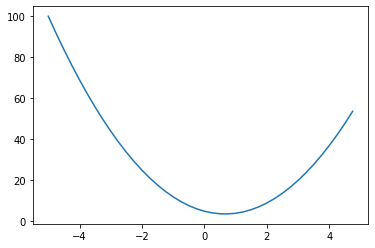

In [4]:
xs = np.arange(-5,5,.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h=0.000000001
x=2/3
(f(x+h)-f(x))/h

0.0

In [6]:
# lets get more complex
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [24]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #backpropagation, by default nothing to do
        self._prev = set(_children) #record the children
        self._op = _op
        self.label = label
    
    #repr makes the printed values readable
    def __repr__(self):
        return f"Value(data={self.data})"
    
    #use double score in phyton to change default operators
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # = instead of += below in original implementation
            self.grad += 1.0 * out.grad  #transfer grad + bugfix accumulate due to multivariable case of chain rule
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # = instead of += below in original implementation
            self.grad += other.data * out.grad #chainrule + bugfix: accumulate due to multivariable case of chain rule
            other.grad += self.data * out.grad 
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # = instead of += below in original implementation
            self.grad += (1 - t**2) * out.grad #local derivate of tanh times out.grad due to chain rule + bugfix: accumulate due to multivariable case of chain rule
        out._backward = _backward
                
        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v): #build topo from the top object down to its all children, start adding the bottom most child
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0 #required because its initilized as 0, but is 1.0 for topmost node
        for node in reversed(topo): #iterating in topo in reserve order, since top node shall the start point for backpropagation
            node._backward()
            

In [9]:
#Install graphviz on your system from terminal (brew install graphviz)
from graphviz import Digraph

def trace(root) :
    # builds a set of all nodes and edges in a graph
    nodes, edges = set (), set ()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges. add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node (name = uid, label = " %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

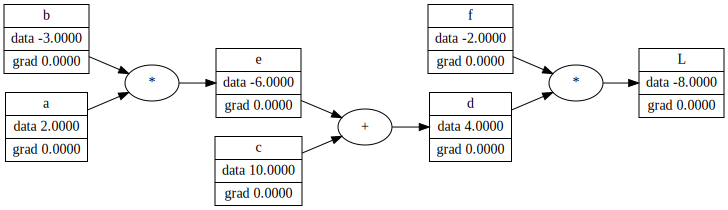

In [11]:
draw_dot(L) #minute-mark 31:00

In [12]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

#Calculus chain rule dL / dc = dL / dd * dd/ dc = -2 * 1 = -2 plus node transfers the gradient 
c.grad = -2.0
e.grad = -2.0

#Calculus chain rule dL / da = dL / de * de / da = -2 * -3 = 6 
a.grad = 6
b.grad = -4


In [13]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

-4.000000000008441


In [14]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e=a*b
d=e+c
L=d*f

print(L.data)

-7.286496


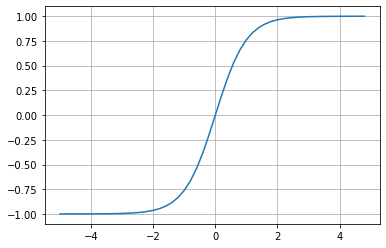

In [15]:
#activation function - squashing fuction: sigmoid or tanh, inputs (X) are squashed (at Y)
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [28]:
# inputs x1, x2
x1 = Value (2.0, label='x1')
x2 = Value (0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label='n' 
o= n.tanh(); o.label='o'

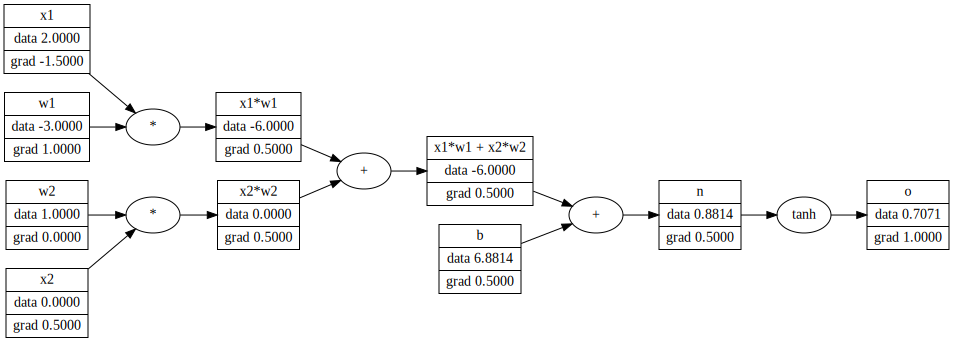

In [31]:
draw_dot(o)

In [18]:
# manual backpropagation
n.grad = 0.5
# plus node transfers the gradient, so
x1w1x2w2.grad = 0.5
b.grad = 0.5
# again plus node transfering
x1w1.grad = 0.5
x2w2.grad = 0.5
# mult will have a grad of other multipier times the grad from previous node - chainrule
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [19]:
#automatic backpropagation, one by one
o.grad = 1.0 #required because its initilized as 0, and its slope is one since it is itself.

o._backward()

n._backward()

b._backward() #will do nothing since b is a leaf node, and has no back node
x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()

x1._backward()
w1._backward()
x2._backward()
w2._backward()

In [20]:
#fully automated backpropagation by topological order - this is added to Value Class
o.grad = 1.0 #required for same reason as above

topo = []
visited = set()
def build_topo(v): #build topo from the top object down to its all children, start adding the bottom most child
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
print(topo)

for node in reversed(topo): #iterating in topo in reserve order, since top node shall the start point for backpropagation
    node._backward()

[Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=1.0), Value(data=0.0), Value(data=0.0), Value(data=-6.0), Value(data=6.881373587019543), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


In [30]:
#fully automated backpropagation, using implemented Class method (code in previous line as well)
o.backward()

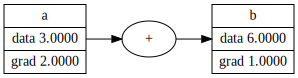

In [26]:
#bug in the original implementation for fully automated backpropagation
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

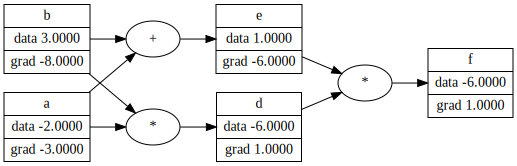

In [25]:
#another demo bug in the original implementation for fully automated backpropagation
a=Value(-2.0, label='a')
b=Value(3.0, label='b')
d=a * b; d.label='d'
e=a + b; e.label='e'
f=d * e; f.label='f'
f.backward()
draw_dot(f)
#bug occur when one variable is used more than once
#bugfixed in Value class grad assignments with accumulation due to multivariable case of chain rule

In [ ]:
# Finished first part before code cleaning by AK at 1h:26m:35s